# Visualize model predictions

Ensure that samples entered are in the test set or validation set

In [67]:
import os
import sys
from pytorch_lightning import Trainer
import albumentations as A
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import numpy as np

sys.path.append('.')
#from models.UNet_mateuszbuda import UNet_m
from models.UNet_L import UNet_no_val
from models.loss import DiceLoss, DiceLoss2

from run_pretraining import get_dataset

from data.CTDataSet import CTDicomSlices, DatasetManager
from data.CustomTransforms import Window, Imagify, Normalize

from tests.test_CTDataSet import plot_slices_and_mask

from data.holdout import read_list

### Plotting function

In [68]:
def plot_img_and_mask(img, predictions, prediction_labels, mask):
    #mask = mask * 255 // 4
    #prediction = prediction * 255 // 4
    
    img = img.numpy()
    mask = mask.numpy()
    predictions = [prediction.numpy() for prediction in predictions]

    
    fig = plt.figure(figsize=(21,21))
    cols, rows = 1, 2 + len(predictions)
    
    fig.patch.set_facecolor('white')
    
    fig.add_subplot(rows, cols, 1)
    plt.title('CT Slice')
    plt.imshow(img, cmap='gray')

    for i, pred in enumerate(predictions):
        fig.add_subplot(rows, cols, 2 + i)    # plt uses 1-based indices. i uses 0-based indices. This will be second location
        plt.title(prediction_labels[i])
        plt.imshow(img, cmap='gray')
        plt.imshow(pred, cmap='jet', alpha=0.3)
    
    fig.add_subplot(rows, cols, 2 + len(predictions))
    plt.title('Ground truth')
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.3)
    
    plt.show()

### Some constants

### Collect Models

In [70]:
def list_maker(l):
    l = l.split("\n")
    l = [s.strip() for s in l]
    return l

In [71]:
model_checkpoints = list_maker("""/mnt/d/pretrainer/model_runs/best_model/logs/default/version_0/checkpoints/epoch=99-step=226899.ckpt
                        /mnt/d/pretrainer/model_runs/random_nopretrain_nooptim/logs/default/version_0/checkpoints/epoch=99-step=226899.ckpt""")

model_names = list_maker("""ImageNet weights
                            Random weights""")

`ModelLoc class` allows us to keep track of model cehck points and get the location of their DICOM lists. It also allows to easily verify that they were trained, validated and tested on identical lists of DICOMS.

In [72]:
class ModelLoc():
    def __init__(self, model_checkpoint_file, name = ""):
        self.model_checkpoint_file = model_checkpoint_file
        self.model = None
        self.name = name

    @staticmethod
    def generateModelLocList(model_checkpoint_files, model_names = None):
        models = [None] * len(model_checkpoint_files)

        for i in range(len(model_checkpoint_files)):
            if model_names is not None:
                models[i] = ModelLoc(model_checkpoint_files[i], name = model_names[i])
            else:
                models[i] = ModelLoc(model_checkpoint_files[i])

        return models

    def get_model_dir(self):
        main_folder_index = self.model_checkpoint_file.find("/logs/default/version_0/checkpoints/")
        return self.model_checkpoint_file[0:main_folder_index]
    
    def get_model(self):
        if self.model is None:
            self.model = UNet_no_val.load_from_checkpoint(self.model_checkpoint_file, datasets=None, in_channels=3, classes=2)

        return self.model
    
    def get_train_val_test_dicom_lists(self):
        """ Gets the lists of DICOMS that were used to train, validate and test the model. """
        model_dir = self.get_model_dir()

        train_p = "{}/train.txt".format(model_dir)
        val_p = "{}/val.txt".format(model_dir)
        test_p = "{}/test.txt".format(model_dir)

        train_l = read_list(train_p)
        val_l = read_list(val_p)
        test_l = read_list(test_p)

        return train_l, val_l, test_l

    @staticmethod
    def assertSameDatasets(models):
        """ Takes a list of ModelLocs and confirms that their train, val and test sets are identical. """

        train_l, val_l, test_l = models[0].get_train_val_test_dicom_lists()

        for modelLoc in models:
            t, v, ts = modelLoc.get_train_val_test_dicom_lists()

            if t != train_l or v != val_l or ts != test_l:
                return False
            

        return True

Now assert that all models were trained on identical datasets.

In [73]:
models = ModelLoc.generateModelLocList(model_checkpoints, model_names)

assert ModelLoc.assertSameDatasets(models), "Model datasets are not identical."

print("All model datasets are identical.")

All model datasets are identical.


### Constants and transforms

In [74]:
test_set = True

WL = 50
WW = 200

img_size = 256

mean = 61.0249
std = 78.3195

In [75]:
prep = transforms.Compose([Window(WL, WW), Imagify(WL, WW), Normalize(mean, std)])

resize_tsfm = A.Compose([A.Resize(img_size, img_size)],
            additional_targets={"image1": 'image', "mask1": 'mask'})

### Build the relevant datasets

In [76]:
main_dir = "/mnt/d/pretrainer/model_runs"
model_name = "2021-05-31-19_17_23"
model_dir = "{}/{}".format(main_dir, model_name)
checkpoint_f = 'epoch=99-step=226899.ckpt'

#dataset = "../organized_dataset_2"
dataset = '/home/hussam/imager/organized_dataset_2'

if test_set:
    dsm = DatasetManager.load_train_val_test(dataset, "{}/train.txt".format(model_dir), "{}/val.txt".format(model_dir), "{}/test.txt".format(model_dir))

    train_dicoms, val_dicoms, test_dicoms = dsm.get_dicoms() # DICOM glob is preset in the class file

    test_ds = CTDicomSlices(test_dicoms, preprocessing = prep, resize_transform = resize_tsfm, n_surrounding=1, mask_is_255=False)

    test_dl = DataLoader(test_ds, batch_size=1, num_workers = 0, shuffle=True)
    
else:
    dcm_list = CTDicomSlices.generate_file_list(dataset, dicom_glob='/*/dicoms/*.dcm')

    ds = CTDicomSlices(dcm_list, preprocessing = prep,
                        resize_transform = resize_tsfm, n_surrounding=1, mask_is_255=False)
                        
    test_dl = DataLoader(ds, batch_size = 1, num_workers = 0, shuffle = True)

In [77]:
model = models[0].get_model()

Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0553/dicoms/90.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0348/dicoms/377.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0320/dicoms/4.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0509/dicoms/29.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0351/dicoms/187.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0603/dicoms/221.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0509/dicoms/35.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0439/dicoms/266.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0356/dicoms/141.dcm',)
Mask sum is 201705 and max is 255


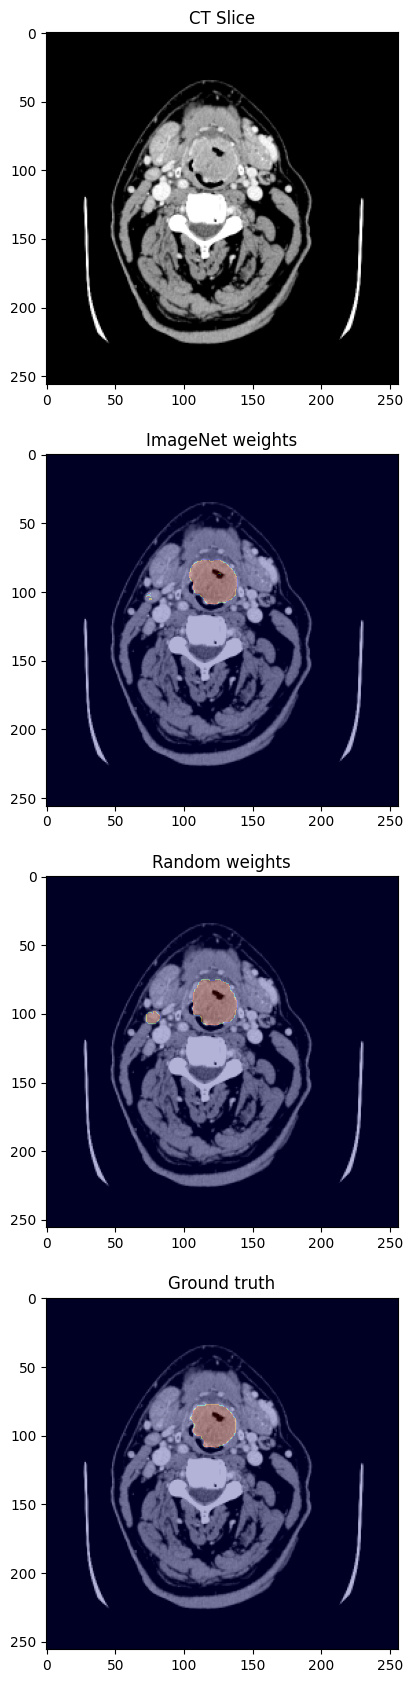

Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0603/dicoms/3.dcm',)
Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0414/dicoms/177.dcm',)
Mask sum is 406980 and max is 255


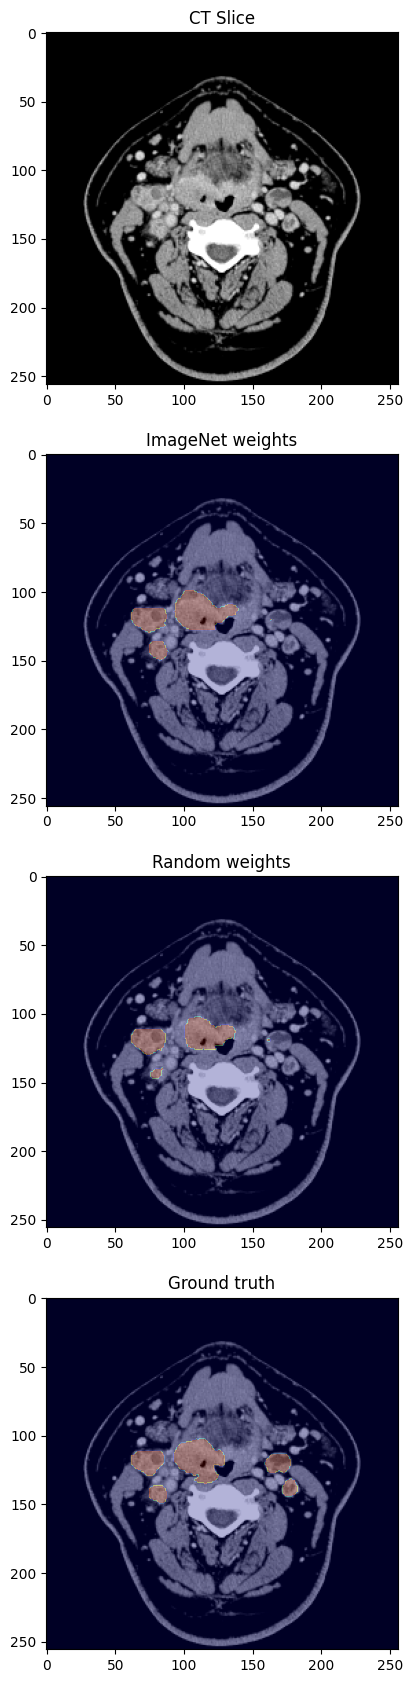

Input file is: ('/home/hussam/imager/organized_dataset_2/HNSCC-01-0414/dicoms/146.dcm',)
Mask sum is 30600 and max is 255


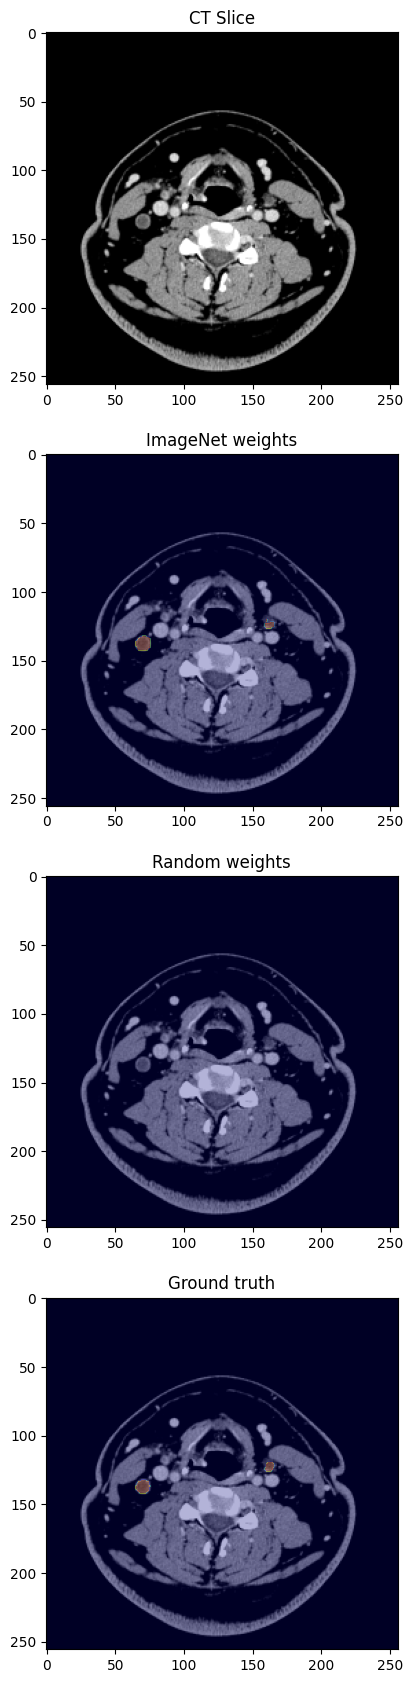

In [79]:
max = 3

for i, (slices, mask, img_path, slice_n) in enumerate(test_dl):  
    if i >= max:
        break

    #print("Model WL: {} - WW: {}".format(WL, WW))
    print("Input file is: {}".format(img_path)) 

    y_preds = [None] * len(models)

    for i, m in enumerate(models):
        y_preds[i] = m.get_model()(slices)
   
    if (torch.sum(mask) == 0 and sum([torch.sum(torch.round(y_pred)) == 0 for y_pred in y_preds]) == 0):
        max += 1
        continue

    print("Mask sum is {} and max is {}".format(torch.sum(mask), torch.max(mask)))
    plot_img_and_mask(slices[0,:,:,1], [torch.round(y_pred[0,0,:,:].detach()) for y_pred in y_preds], model_names, mask[0])
    
